In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt


base_path = '/content/drive/MyDrive/Data_Project/'

def load_images(base_path, label, img_size=(32, 32)):
    """Load images from the given path and return them with labels."""
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')
    for filename in os.listdir(base_path):
        if filename.endswith(valid_extensions):
            # Construct the full path to the image
            file_path = os.path.join(base_path, filename)
            # Open the image and resize it
            with Image.open(file_path) as img:
                img = img.resize(img_size)  # Resize image
                img = img.convert('L')  # Convert to grayscale
                img_array = np.array(img)  # Convert image to numpy array
                images.append(img_array.flatten())  # Flatten the image and append to list
                labels.append(label)
    return np.array(images), np.array(labels)



train_autos, train_auto_labels = load_images(base_path + 'Cars Dataset/train', label=0)
train_motorcycles, train_motorcycle_labels = load_images(base_path + 'Motorcycle Dataset/train/motorbike', label=1)
test_autos, test_auto_labels = load_images(base_path + 'Cars Dataset/test', label=0)
test_motorcycles, test_motorcycle_labels = load_images(base_path + 'Motorcycle Dataset/test/motorbike', label=1)


X_train = np.vstack((train_autos, train_motorcycles))
y_train = np.hstack((train_auto_labels, train_motorcycle_labels))
X_test = np.vstack((test_autos, test_motorcycles))
y_test = np.hstack((test_auto_labels, test_motorcycle_labels))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training Accuracy: 99.96%
Test Accuracy: 88.85%


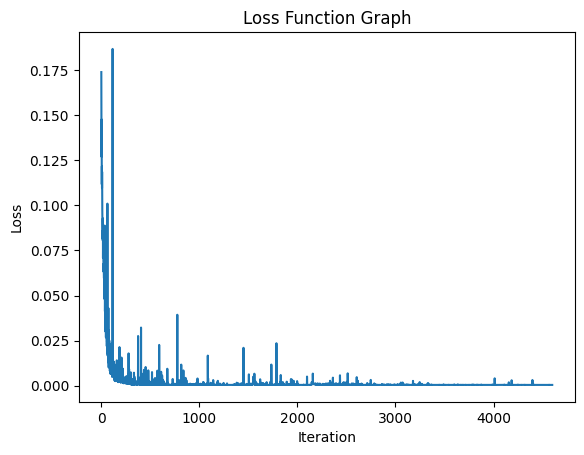

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0


class SimpleNN:
    def __init__(self, layer_sizes, dropout_rate=0.5):
        self.layer_sizes = layer_sizes
        self.dropout_rate = dropout_rate
        self.weights, self.biases = self.initialize_weights()
        self.activations = []
        self.loss_history = []

    def initialize_weights(self):
        weights = []
        biases = []
        for i in range(len(self.layer_sizes) - 1):
            weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2. / self.layer_sizes[i]))
            biases.append(np.zeros((1, self.layer_sizes[i + 1])))
        return weights, biases

    def feedforward(self, X, is_training=True):
        activation = X
        self.activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            activation = np.maximum(z, 0)  # ReLU activation
            if i < len(self.weights) - 1 and is_training:
                mask = (np.random.rand(*activation.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
                activation *= mask
            self.activations.append(activation)
        return activation

    def backprop(self, X, y, learning_rate):
        activations = self.activations
        deltas = [activations[-1] - y[:, None]]

        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * (activations[i] > 0).astype(float)
            deltas.insert(0, delta)

        for i in range(len(self.weights)):
            d_weights =np.dot(activations[i].T, deltas[i])
            d_biases = np.sum(deltas[i], axis=0, keepdims=True)
            self.weights[i] -= learning_rate * d_weights
            self.biases[i] -= learning_rate * d_biases

    def compute_loss(self, X, y):
      predictions = self.feedforward(X, is_training=False)
      loss = np.mean((predictions - y[:, None]) ** 2)
      return loss

    def train(self, X, y, batch_size, iterations, learning_rate):
        for i in range(iterations):
            indices = np.random.permutation(len(X))
            for start_idx in range(0, len(X) - batch_size + 1, batch_size):
                excerpt = indices[start_idx:start_idx + batch_size]
                self.feedforward(X[excerpt], is_training=True)
                self.backprop(X[excerpt], y[excerpt], learning_rate)
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

def evaluate_model(nn, X, y):
    predictions = nn.feedforward(X, is_training=False) >= 0.5
    accuracy = np.mean(predictions == y[:, None])
    return accuracy

def plot_loss(nn):
    plt.plot(nn.loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Function Graph')
    plt.show()
# Parameters
input_size = 32 * 32
hidden_sizes = [100, 50]
output_size = 1
layer_sizes = [input_size] + hidden_sizes + [output_size]

nn = SimpleNN(layer_sizes, dropout_rate=0.2)
nn.train(X_train, y_train, 16, 4600, 0.005)
print(f"Training Accuracy: {evaluate_model(nn, X_train, y_train) * 100:.2f}%")
print(f"Test Accuracy: {evaluate_model(nn, X_test, y_test) * 100:.2f}%")



plot_loss(nn)

In [ ]:
def cross_validate(nn_class, X, y, k_folds=5, batch_size=16, iterations=4700, learning_rate=0.005):
    fold_size = len(X) // k_folds
    accuracies = []

    for i in range(k_folds):
        # Split the data into training and validation sets
        start, end = i * fold_size, (i + 1) * fold_size
        X_val, y_val = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])

        nn = nn_class(layer_sizes, dropout_rate=0.2)
        nn.train(X_train, y_train, batch_size, iterations, learning_rate)

        # Evaluate the model on the validation set
        val_accuracy = evaluate_model(nn, X_val, y_val)
        accuracies.append(val_accuracy)

        print(f"Fold {i + 1}/{k_folds} - Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Calculate the average accuracy across all folds
    avg_accuracy = np.mean(accuracies)
    print(f"Average Cross-Validation Accuracy: {avg_accuracy * 100:.2f}%")
    return avg_accuracy


cross_validate(SimpleNN, X_train, y_train, k_folds=5)


Fold 1/5 - Validation Accuracy: 83.30%


<ipython-input-4-0b19d0682910>:38: RuntimeWarning: invalid value encountered in multiply
  delta = np.dot(deltas[0], self.weights[i].T) * (activations[i] > 0).astype(float)


Fold 2/5 - Validation Accuracy: 100.00%
Fold 3/5 - Validation Accuracy: 85.83%
Fold 4/5 - Validation Accuracy: 81.36%
Fold 5/5 - Validation Accuracy: 79.61%
Average Cross-Validation Accuracy: 86.02%


0.8601941747572817

In [ ]:
def compute_confusion_matrix(y_true, y_pred, num_classes=2):
    """Compute the confusion matrix for a binary classification problem."""
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[int(true), int(pred)] += 1
    return cm

# Generate predictions
train_predictions = nn.feedforward(X_train, is_training=False) >= 0.5
test_predictions = nn.feedforward(X_test, is_training=False) >= 0.5

train_predictions = train_predictions.flatten()
test_predictions = test_predictions.flatten()

# Compute confusion matrices
train_confusion_matrix = compute_confusion_matrix(y_train, train_predictions)
test_confusion_matrix = compute_confusion_matrix(y_test, test_predictions)

print("Train Confusion Matrix:")
print(train_confusion_matrix)

print("Test Confusion Matrix:")
print(test_confusion_matrix)

Train Confusion Matrix:
[[1202    1]
 [   0 1374]]
Test Confusion Matrix:
[[539  56]
 [ 89 617]]
